In this term project, I will present several demosaic algorithms. Some of them are programmed by codes. Some of them are functions from libraries. I will try to demosaic the same picture with various algorithms and compare their differences.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
from time import gmtime, strftime, sleep
import re
from scipy import interpolate as interp
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/home/handricks/anaconda3/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [2]:
def grabImage(sid=2, imres=8, fm=1, cameraNumber=9):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='rsh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='rcp ubuntu@10.0.1.'+str(cameraNumber)
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 --dump-bayer\
                    --file-name dbGrab --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    if fm==1:
        fileName = re.search(r'dbGrab(.*).jpg', rePop)
        fileName=fileName.group()
        pop=imio.imread(fileName)
    else:
        fileName = re.search(r'(.*).raw', rePop)
        fileName=fileName.group()
        pop=np.fromfile(fileName,dtype=np.dtype('i2'))
        rows=2190
        runL=3864
        pop=np.reshape(pop[:rows*runL],(rows,runL))
    return pop

/home/handricks/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


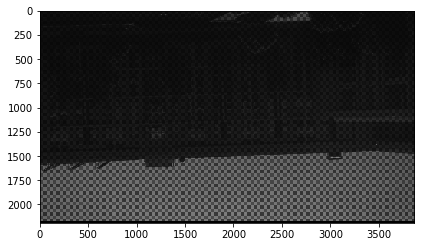

In [3]:
b=grabImage(sid=1, fm=2)
imio.imshow(b)

1.The first demosaic codes are from professor Brady.

In [4]:
def demosaic(rawImage):  
    red=rawImage[0:2160:2,0:3840:2]
    redU=interp.RectBivariateSpline(np.arange(0,1080),np.arange(0,1920),red)
    red=redU(np.arange(0,1080,.5),np.arange(0,1920,.5))
    blue=rawImage[1:2160:2,1:3840:2]
    blueU=interp.RectBivariateSpline(np.arange(0,1080),np.arange(0,1920),blue)
    blue=blueU(np.arange(0,1080,.5),np.arange(0,1920,.5))
    green=rawImage;
    for er in range(0,2159,2):
        for odr in range(0,3862,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    for er in range(1,2160,2):
        for odr in range(1,3862,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    greenU=interp.RectBivariateSpline(np.arange(0,2160),np.arange(0,3862),green[0:2160,0:3862])
    green=greenU(np.arange(0,2160,1),np.arange(0,3840,1))
    imageOut=np.dstack((red,green,blue))
    imageOut=255*imageOut/np.max(imageOut)
    imageOut=imageOut.astype(np.uint8)
    return imageOut

/home/handricks/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


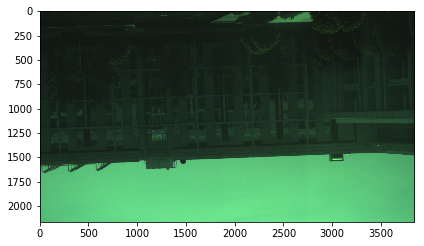

In [5]:
b1=demosaic(b)
imio.imshow(b1)

Then I will try some color adjusting methods to make the pictures look like the real one as much as possible

In [6]:
def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]
    fI=gain*fI/np.max(fI)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI

/home/handricks/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


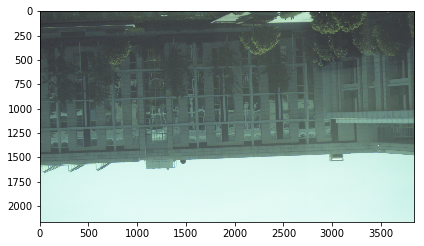

In [7]:
c1=adjustColor(b1,rc=1.2,bc=1.2,gc=.9,gain=5,contrast=.7)
imio.imshow(c1)

2.The second and algorithms also adopt the intepolation method with only a few differences.

In [8]:
def demosaic1(rawImage):
    red1=rawImage[1:2161:2,0:2048:2]
    red2=rawImage[0:2160:2,2048:3840:2]   
    blue1=rawImage[0:2160:2,1:2049:2]
    blue2=rawImage[1:2161:2,2049:3841:2]   
    green1=rawImage[0:2160:2,0:2048:2]
    green2=rawImage[0:2160:2,2049:3841:2]
    
    red=np.append(red2 ,red1,axis=1)
    blue=np.append(blue2 ,blue1,axis=1)
    green=np.append(green2 ,green1,axis=1)
    
    red_rect=interp.RectBivariateSpline(np.arange(0,1080),np.arange(0,1920),red)
    red=red_rect(np.arange(0,1080,.5),np.arange(0,1920,.5))
    blue_rect=interp.RectBivariateSpline(np.arange(0,1080),np.arange(0,1920),blue)
    blue=blue_rect(np.arange(0,1080,.5),np.arange(0,1920,.5))  
    green_rect=interp.RectBivariateSpline(np.arange(0,1080),np.arange(0,1920),green)
    green=green_rect(np.arange(0,1080,.5),np.arange(0,1920,.5))
    
    imageOut=np.dstack((red,green,blue))
    imageOut=255*imageOut/np.max(imageOut)
    imageOut=imageOut.astype(np.uint8)
    return imageOut

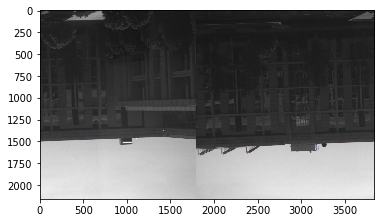

In [9]:
b2=demosaic1(b)
plt.imshow(b2)

/home/handricks/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


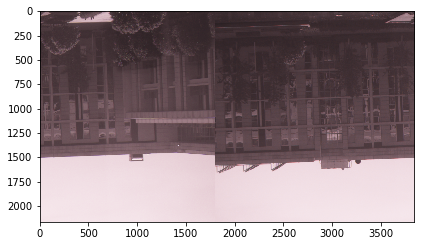

In [10]:
c2=adjustColor(b2,rc=5.2,bc=4.2,gc=3.9,gain=3,contrast=0.7)
imio.imshow(c2)

In [15]:
def demosaic2(rawImage):  
    red=rawImage
    for er in range(1,2159,2):
        for odr in range(0,3862,2):
            red[er,odr]=np.mean([red[er-1,odr], red[er+1,odr]])
    for er in range(0,2160,2):
        for odr in range(1,3862,2):
            red[er,odr]=np.mean([red[er,odr-1], red[er,odr+1]])
    for er in range(1,2160,2):
        for odr in range(1,3862,2):
            red[er,odr]=np.mean([red[er-1,odr-1],red[er+1,odr+1]])
    blue=rawImage
    for er in range(1,2160,2):
        for odr in range(2,3862,2):
            blue[er,odr]=np.mean([blue[er,odr-1], blue[er,odr+1]])
    for er in range(2,2160,2):
        for odr in range(1,3862,2):
            blue[er,odr]=np.mean([blue[er-1,odr], blue[er+1,odr]])
    for er in range(2,2160,2):
        for odr in range(2,3862,2):
            blue[er,odr]=np.mean([blue[er-1,odr-1],blue[er+1,odr+1]])
    green=rawImage;
    for er in range(0,2159,2):
        for odr in range(0,3862,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    for er in range(1,2160,2):
        for odr in range(1,3862,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    imageOut=np.dstack((red,green,blue))
    imageOut=imageOut[0:2159,0:3840,:]
    imageOut=imageOut-np.min(imageOut)
    imageOut=255*np.tanh(2*imageOut/np.max(imageOut))
    imageOut=imageOut.astype(np.uint8)
    return imageOut
            

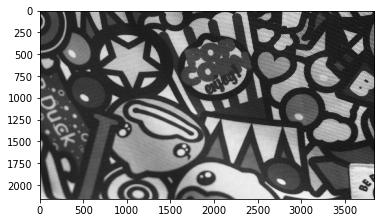

In [16]:
b3=demosaic2(b)
plt.imshow(b3)

/home/handricks/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


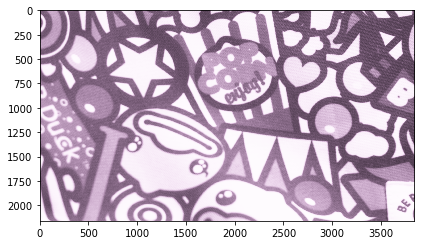

In [20]:
c3=adjustColor(b3,rc=1.2,bc=1.2,gc=.9,gain=5,contrast=.7)
imio.imshow(c3)

The third one also utilize the principle of interpolation but with more specific calculation and gamma correction.

In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:

##The following are some useful functions

def show_hist(x, bins='auto', xlabel="pixel value", ylabel="count", normed=False, color = None):
    plt.hist(x, bins=bins, range=(x.min(), x.max()), normed=normed, color=color )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def print_region(x, patch = [5, 5], fro = [0, 0]):
    print (x[fro[0]:fro[0]+patch[0], fro[1]:fro[1]+patch[1]])

def print_region_rgb(x, p = [5, 5], f = [0, 0]):
    print ("r\n")
    print_region(x[:,:,0], p, f)
    print ("g\n")
    print_region(x[:,:,1], p, f)
    print ("b\n")
    print_region(x[:,:,2], p, f)

def gamma_correction(x, gamma = 2.2):
    return x**gamma

def normalize(x):
    return x / x.max()

Size:  (2190, 3864)
Total pixels:  8462160
Mean:  3126.1916711572458
Var:  4645681.474170962
Min:  0
First Quartile:  1680.0
Median:  2162.0
Second Quartile:  4100.0
Max:  14268


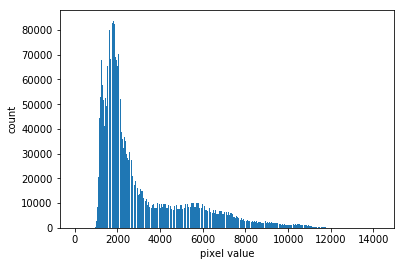

In [45]:
unprocessed_raw = np.array(b)

print ("Size: ", unprocessed_raw.shape)
print ("Total pixels: ", unprocessed_raw.size)

print ("Mean: ", unprocessed_raw.mean())
print ("Var: ", unprocessed_raw.var())

print ("Min: ", unprocessed_raw.min())
print ("First Quartile: ", np.percentile(unprocessed_raw, 25))
print ("Median: ", np.median(unprocessed_raw))
print ("Second Quartile: ", np.percentile(unprocessed_raw, 75))
print ("Max: ", unprocessed_raw.max())

show_hist(unprocessed_raw.reshape([-1]), 1000)

unprocessed_raw = unprocessed_raw.astype("float64")

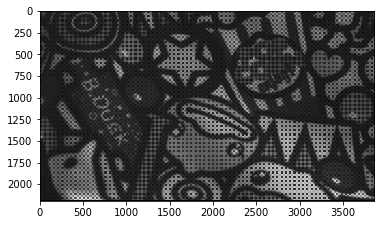

In [46]:
# Take a look at unprocessed raw.
plt.imshow(unprocessed_raw, cmap='gray')

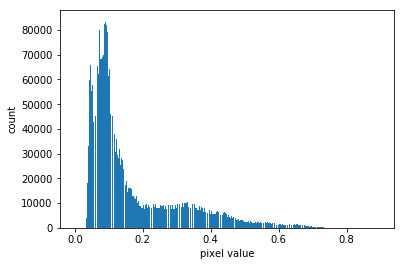

In [47]:
# From EXIFTOOL:
Black_level = 512
White_level = 15360


# Step 1:
# Clip, Scale to [0, 1]
def scale_color(x, wl, bl):
    y = x.copy()
    y[y > wl] = wl
    y[y < bl] = bl
    y = (y - bl) / wl
    return y

scale_clip = scale_color(unprocessed_raw, White_level, Black_level)

# Sanity check
show_hist(scale_clip.reshape([-1]), 1000)

In [48]:
# From EXIFTOOL:
# Photometric Interpolation: Color Filter Array
# CFA Pattern: bayer pattern


# FROM EXIFTOOL:
WB_rggb = np.array([1988, 1024, 1024, 2000]) / 1024.
print (WB_rggb)
# Step 2: color scale (white balance)

color_scale = scale_clip
color_scale[0::2, 0::2] *= WB_rggb[0]    #R
color_scale[1::2, 0::2] *= WB_rggb[1]    #G1
color_scale[0::2, 1::2] *= WB_rggb[2]    #G2
color_scale[1::2, 1::2] *= WB_rggb[3]    #B

[1.94140625 1.         1.         1.953125  ]


In [49]:
# Step 3: interpolation mono->tricolor
# interpolation method:

def nn (mono):
    r = mono[0::2, 0::2]
    g = (mono[1::2, 0::2] + mono[0::2, 1::2]) / 2
    b = mono[1::2, 1::2]
    rgb = np.zeros([r.shape[0], r.shape[1], 3])
    rgb[:,:,0] = r
    rgb[:,:,1] = g
    rgb[:,:,2] = b
    return rgb

demosaicked = nn(color_scale)

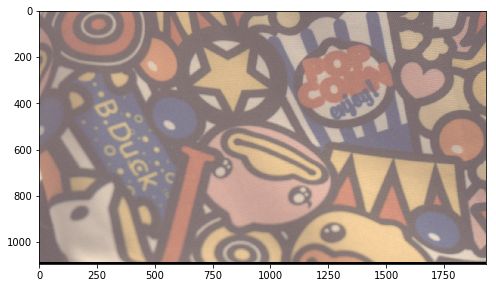

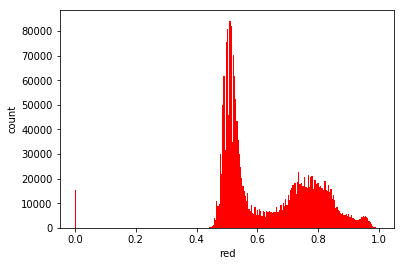

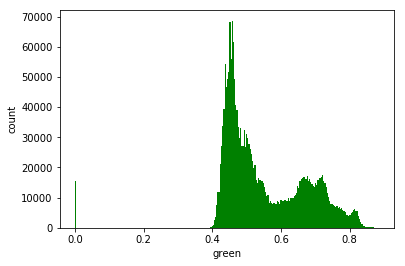

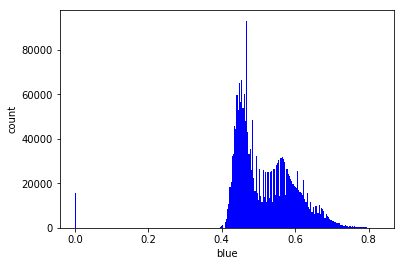

In [50]:
# Step 4: perform gamma correction.
g_correct = normalize(gamma_correction(demosaicked, 0.3))

plt.figure(figsize=(8,16))
plt.imshow(g_correct)

plt.figure()
show_hist(g_correct[:,:,0].reshape([-1]), 256, 'red', color = 'red')
plt.figure()
show_hist(g_correct[:,:,1].reshape([-1]), 256, 'green', color = 'green')
plt.figure()
show_hist(g_correct[:,:,2].reshape([-1]), 256, 'blue', color = 'blue')

In this manual demosaic algorithm, I have tried many times, but I got different results every time. So I doubt that the outcome of one algorithm is related to the environmen. Meanwhile, the outcome is also connected to the performance of one computer.

The next one is linear interpolation.Due to the particularity of the algorithm, I adopt some special png pictures instead of the raw files from our camera to do the test. I will demosaic the lighthouse and the sign.

In [69]:
%pylab
from scipy import ndimage 

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/home/handricks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


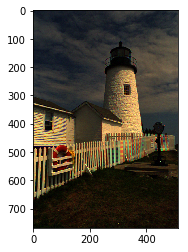

In [76]:
rawImage = ndimage.imread('./lighthouse_RAW_noisy_sigma0.01.png')
import numpy as np

width, height = rawImage.shape
pattern = [['r', 'g'],
           ['g', 'b']]

def linearInterpolate(rawImage, targetColor, pattern, x, y):
    patternDelta = (x % 2, y % 2)
    pixelColorType = pattern[patternDelta[0]][patternDelta[1]]
    
    targetColorDelta = (-1, -1)
    if targetColor in pattern[0]:
        targetColorDelta = (pattern[0].index(targetColor), 0)
    if targetColor in pattern[1]:
        targetColorDelta = (pattern[1].index(targetColor), 1)

    if targetColorDelta == (-1, -1):
        return 0

    xOffset = abs(patternDelta[0] - targetColorDelta[0])
    yOffset = abs(patternDelta[1] - targetColorDelta[1])

    interpolationPoints = [
        (x - xOffset, y - yOffset),
        (x + xOffset, y - yOffset),
        (x - xOffset, y + yOffset),
        (x + xOffset, y + yOffset)
    ]
    
    interpolationPoints = filter(lambda xy: xy[0] > -1 and xy[0] < rawImage.shape[0], interpolationPoints)
    interpolationPoints = filter(lambda xy: xy[1] > -1 and xy[1] < rawImage.shape[1], interpolationPoints)
    interpolationPoints = list(set(interpolationPoints))
    valuePoints = list(map(lambda xy: rawImage[xy], interpolationPoints))
    return float(sum(valuePoints)) / len(valuePoints)
        
def computeColor(rawImage, pattern, targetColor, isReal, x, y):
    if isReal:
        return rawImage[x, y]
    else:        
        return linearInterpolate(rawImage, targetColor, pattern, x, y)
    
result = []
for x in range(width):
    for y in range(height):
        isRealR = pattern[x % 2][y % 2] == 'r'
        isRealG = pattern[x % 2][y % 2] == 'g'
        isRealB = pattern[x % 2][y % 2] == 'b'
        
        rValue = computeColor(rawImage, pattern, 'r', isRealR, x, y)
        gValue = computeColor(rawImage, pattern, 'g', isRealG, x, y)
        bValue = computeColor(rawImage, pattern, 'b', isRealB, x, y)
        result.append((rValue, gValue, bValue))
        
result = np.asarray(result).reshape(width, height, 3)
imshow(result / 255.0)

/home/handricks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


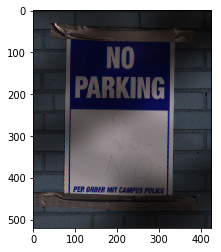

In [78]:
rawImage = ndimage.imread('./signs-small.png')
import numpy as np

width, height = rawImage.shape
pattern = [['r', 'g'],
           ['g', 'b']]

def linearInterpolate(rawImage, targetColor, pattern, x, y):
    patternDelta = (x % 2, y % 2)
    pixelColorType = pattern[patternDelta[0]][patternDelta[1]]
    
    targetColorDelta = (-1, -1)
    if targetColor in pattern[0]:
        targetColorDelta = (pattern[0].index(targetColor), 0)
    if targetColor in pattern[1]:
        targetColorDelta = (pattern[1].index(targetColor), 1)

    if targetColorDelta == (-1, -1):
        return 0

    xOffset = abs(patternDelta[0] - targetColorDelta[0])
    yOffset = abs(patternDelta[1] - targetColorDelta[1])

    interpolationPoints = [
        (x - xOffset, y - yOffset),
        (x + xOffset, y - yOffset),
        (x - xOffset, y + yOffset),
        (x + xOffset, y + yOffset)
    ]
    
    interpolationPoints = filter(lambda xy: xy[0] > -1 and xy[0] < rawImage.shape[0], interpolationPoints)
    interpolationPoints = filter(lambda xy: xy[1] > -1 and xy[1] < rawImage.shape[1], interpolationPoints)
    interpolationPoints = list(set(interpolationPoints))
    valuePoints = list(map(lambda xy: rawImage[xy], interpolationPoints))
    return float(sum(valuePoints)) / len(valuePoints)
        
def computeColor(rawImage, pattern, targetColor, isReal, x, y):
    if isReal:
        return rawImage[x, y]
    else:        
        return linearInterpolate(rawImage, targetColor, pattern, x, y)
    
result = []
for x in range(width):
    for y in range(height):
        isRealR = pattern[x % 2][y % 2] == 'r'
        isRealG = pattern[x % 2][y % 2] == 'g'
        isRealB = pattern[x % 2][y % 2] == 'b'
        
        rValue = computeColor(rawImage, pattern, 'r', isRealR, x, y)
        gValue = computeColor(rawImage, pattern, 'g', isRealG, x, y)
        bValue = computeColor(rawImage, pattern, 'b', isRealB, x, y)
        result.append((rValue, gValue, bValue))
        
result = np.asarray(result).reshape(width, height, 3)
imshow(result / 255.0)

For the last algorithms, I intended to adopt some existed demosaicing functions from OpenImageIo. However, I had some trouble when I tried to install the library. There are many required dependencies before installing the OpenImageIo. I could not install one of the dependencies,OpenEXR, because I could not download the package from the official website despite of many tries. So I will just present all the codes in the following without,however,any outcomes. I will also submit some outcomes coming from these algorithms by other people instead of me. Additionally, I also found the background codes of all the functions, which I will also submit.  

In [79]:
%matplotlib inline

In [80]:
from __future__ import division

import os

import colour
from colour.plotting import *

from colour_demosaicing import (
    EXAMPLES_RESOURCES_DIRECTORY,
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_Menon2007,
    mosaicing_CFA_Bayer)

OETF = colour.RGB_COLOURSPACES['sRGB'].encoding_cctf

/home/handricks/anaconda3/lib/python3.6/site-packages/colour/utilities/verbose.py:141: ColourWarning: "x" independent variable is not uniform, unpredictable results may occur!
  warn(*args, **kwargs)


In [81]:
LIGHTHOUSE_IMAGE = colour.io.read_image(
    os.path.join(EXAMPLES_RESOURCES_DIRECTORY, 'bayer', 'Lighthouse.exr'))

image_plot(OETF(LIGHTHOUSE_IMAGE), 'Lighthouse - R914108 - Kodak')

ImportError: "OpenImageIO" related Api features are not available: "No module named 'OpenImageIO'".

In [82]:
CFA = mosaicing_CFA_Bayer(LIGHTHOUSE_IMAGE)

image_plot(OETF(CFA), 'Lighthouse - CFA - RGGB')

image_plot(OETF(mosaicing_CFA_Bayer(LIGHTHOUSE_IMAGE, 'BGGR')), 
           'Lighthouse - CFA - BGGR')

NameError: name 'LIGHTHOUSE_IMAGE' is not defined

In [83]:

image_plot(OETF(demosaicing_CFA_Bayer_bilinear(CFA)), 
                'Lighthouse - Demosaicing - Bilinear')

NameError: name 'CFA' is not defined

In [84]:
image_plot(OETF(demosaicing_CFA_Bayer_Malvar2004(CFA)), 
                'Lighthouse - Demosaicing - Malvar (2004)')

NameError: name 'CFA' is not defined

In [85]:
image_plot(OETF(demosaicing_CFA_Bayer_Menon2007(CFA)), 
                'Lighthouse - Demosaicing - Menon (2007)')

NameError: name 'CFA' is not defined